Simple interaction example again, but this time comparing different loss functions with outliers.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from vcboost import VCBooster
from vcboost.loss import LS, LAD

# Generate Data

In [2]:
n = 1000  # sample size for this example
n_out = 25  # number of outliers

rng = np.random.default_rng(975)  # set up random number generator

# design matrix for parametric coefficients (intercept plus one covariate)
X = np.ones((n, 2))
X[:, 1] = rng.uniform(-1, 1, n)

Z = rng.choice([0, 1], n)  # effect modifier, either 0 or 1

eps = rng.normal(0, 4, n)  # noise

beta_0 = np.array([-10, 5])  # vector with parametric coefficients
beta_1 = np.array([5, -10])  # another vector with parametric coefficients

# parametric model for y depends on effect modifier Z
y = (X @ beta_0) * (Z == 0) + (X @ beta_1) * (Z == 1) + eps

# add some ugly outliers
out_idx = (np.where(X[:, 1] < -0.7)[0])[:n_out]  # indices in 1, ..., n that contain outliers
out_values = rng.normal(100, 0.5, n_out)  # outlier realizations

y[out_idx] = out_values  # add outliers to y

# also get clean version of dataset with outliers removed
X_clean = np.delete(X, out_idx, axis=0)
Z_clean = np.delete(Z, out_idx, axis=0)
y_clean = np.delete(y, out_idx, axis=0)

# Fit varying coefficient models with different loss functions

In [3]:
model_ls = VCBooster(learning_rate=0.1, n_stages=50, loss=LS())  # first model uses least squares (LS)
model_lad = VCBooster(learning_rate=0.1, n_stages=50, loss=LAD())  # second model uses least absolute deviation (LAD)

# fit LS model to RAW data set and predict RAW data set
y_hat_ls_raw = model_ls.fit(X, Z.reshape(-1, 1), y).predict(X, Z.reshape(-1, 1))

# fit LS model to CLEAN data set and predict RAW data set
y_hat_ls_clean = model_ls.fit(X_clean, Z_clean.reshape(-1, 1), y_clean).predict(X, Z.reshape(-1, 1))

# fit LAD model to RAW data set and predict RAW data set
y_hat_lad_raw = model_lad.fit(X, Z.reshape(-1, 1), y).predict(X, Z.reshape(-1, 1))

# fit LAD model to CLEAN data set and predict RAW data set
y_hat_lad_clean = model_lad.fit(X_clean, Z_clean.reshape(-1, 1), y_clean).predict(X, Z.reshape(-1, 1))

# Inspect results

Figures below show that models using the LS loss function are strongly affected by outliers. The lines for LS estimated on the clean data set differ substantially from the lines estimated using the raw dataset.  
When using the robust LAD loss function the estimated models are not affected by outliers, e.g. the lines are almost the same for both datasets.

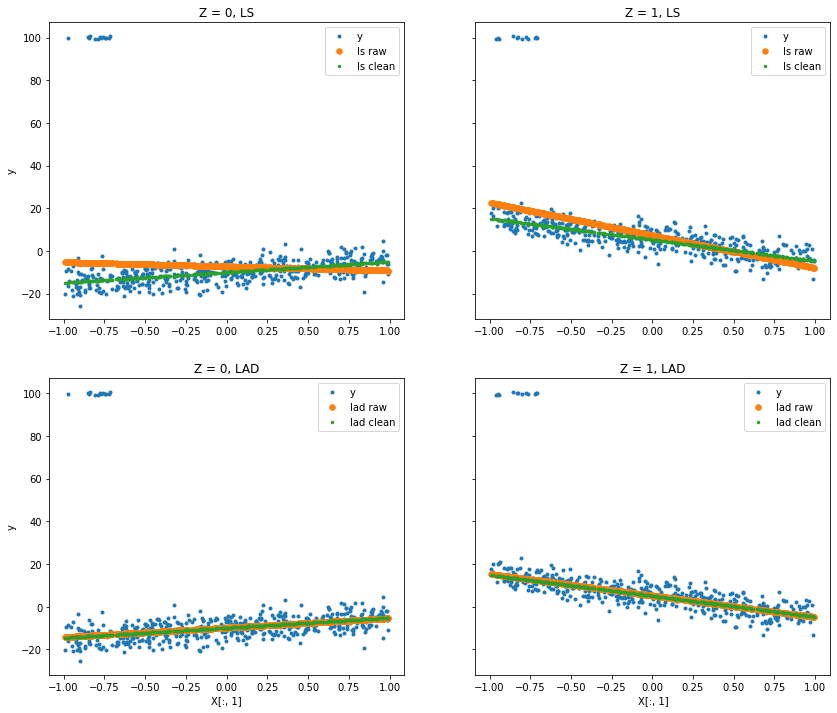

In [4]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(14, 12))

ax[0, 0].plot(X[Z == 0, 1], y[Z == 0], '.', label='y')  # data for Z == 0 in upper row
ax[0, 1].plot(X[Z == 1, 1], y[Z == 1], '.', label='y')  # data for Z == 1 in upper row
ax[1, 0].plot(X[Z == 0, 1], y[Z == 0], '.', label='y')  # data for Z == 0 in lower row
ax[1, 1].plot(X[Z == 1, 1], y[Z == 1], '.', label='y')  # data for Z == 1 in lower row

# plot LS result in upper row
ax[0, 0].plot(X[Z == 0, 1], y_hat_ls_raw[Z == 0], '.', markersize=11, label='ls raw')
ax[0, 1].plot(X[Z == 1, 1], y_hat_ls_raw[Z == 1], '.', markersize=11, label='ls raw')
ax[0, 0].plot(X[Z == 0, 1], y_hat_ls_clean[Z == 0], '.', markersize=5, label='ls clean')
ax[0, 1].plot(X[Z == 1, 1], y_hat_ls_clean[Z == 1], '.', markersize=5, label='ls clean')

# plot LAD results in lower row
ax[1, 0].plot(X[Z == 0, 1], y_hat_lad_raw[Z == 0], '.', markersize=11, label='lad raw')
ax[1, 1].plot(X[Z == 1, 1], y_hat_lad_raw[Z == 1], '.', markersize=11, label='lad raw')
ax[1, 0].plot(X[Z == 0, 1], y_hat_lad_clean[Z == 0], '.', markersize=5, label='lad clean')
ax[1, 1].plot(X[Z == 1, 1], y_hat_lad_clean[Z == 1], '.', markersize=5, label='lad clean')

# add labels and legend
ax[0, 0].set_title('Z = 0, LS'); ax[0, 1].set_title('Z = 1, LS')
ax[1, 0].set_title('Z = 0, LAD'); ax[1, 1].set_title('Z = 1, LAD')
ax[1, 0].set_xlabel('X[:, 1]'); ax[1, 1].set_xlabel('X[:, 1]')
ax[0, 0].set_ylabel('y'); ax[1, 0].set_ylabel('y')

ax[0, 0].legend(); ax[0, 1].legend(); ax[1, 0].legend(); ax[1, 1].legend()